# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Import Libraries

In [1]:
import numpy as np
from numpy.linalg import inv
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Populating the interactive namespace from numpy and matplotlib


## Camera Calibration

### Load images and store corners

In [6]:
vertical_tiles = 6
horizontal_tiles = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((vertical_tiles*horizontal_tiles, 3), np.float32)
objp[:,:2] = np.mgrid[0:horizontal_tiles, 0:vertical_tiles].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (horizontal_tiles, vertical_tiles), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

### Undistort function
**PS**: This function will now work if cell above is not ran previously

In [2]:
def undistort(img):
    global objpoints, imgpoints
    
    img_size = (img.shape[1], img.shape[0])
    
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return cv2.undistort(img, mtx, dist, None, mtx)

### Save the Distortion Values in a pickle

In [11]:
import pickle

data = {'objpoints':objpoints, 'imgpoints':imgpoints}

with open('distortion_var.p', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Test function to undistort

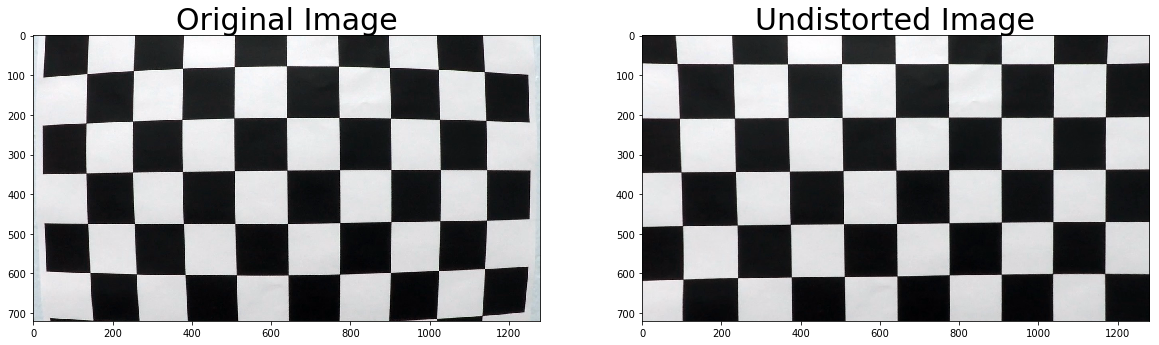

In [8]:
img = cv2.imread('camera_cal/calibration1.jpg')

dst = undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Set Color Scheme To Detect Line

In [3]:
def threshold_image(image, channel, thresh = (0, 255), ft='RGB'):
    assert channel >=0 and channel <=2
    
    if ft == 'HLS':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    if ft == 'HSV':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    if ft == 'RGB':
        img = image
        
    s_channel = img[:,:,channel]
    binary = np.zeros_like(s_channel)
    binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary

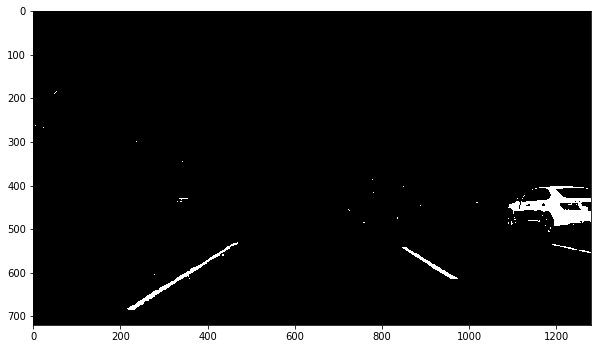

In [4]:
image = mpimg.imread('test_images/test5.jpg')
# image = warped

image_HSV_V = threshold_image(image, channel=2, thresh=(220,255), ft='HSV')

plt.imshow(image_HSV_V, cmap='gray')

In [5]:
image.shape

(720, 1280, 3)

In [6]:
30/720

0.041666666666666664

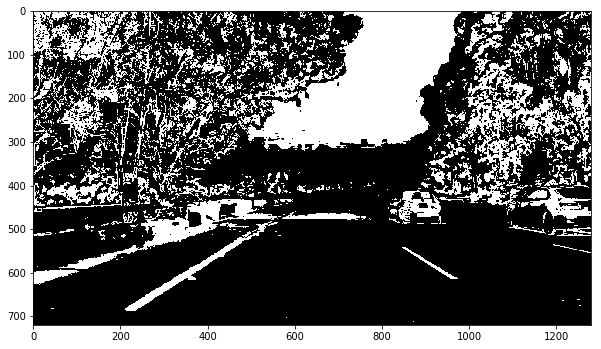

In [7]:
image_HLS_S = threshold_image(image, channel=2, thresh=(90,255), ft='HLS')

plt.imshow(image_HLS_S, cmap='gray')

### Combine Color Images

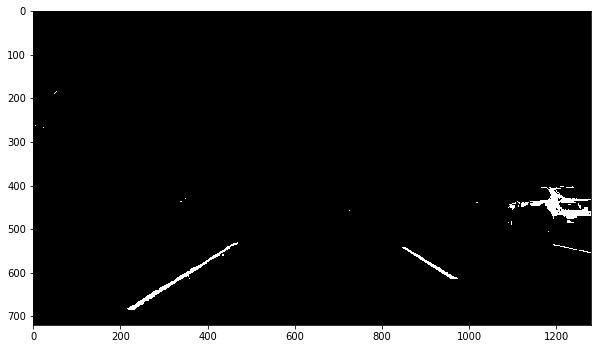

In [8]:
combined_color = np.zeros_like(image_HSV_V)

combined_color[((image_HSV_V == 1) & (image_HLS_S == 1))] = 1

plt.imshow(combined_color, cmap='gray')

In [ ]:
dst = undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Set Gradient Scheme

In [7]:
''' Returns the directional gradient given an angle threshold '''

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


''' Returns an image with the combine magnitude of gradients X & Y bounded by a threshold '''

def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output


''' Returns an image with the gradient accordingly to one direction bounded by a threshold '''

def single_axis_threshold(image, axis, sobel_kernel=3, thresh=(0,255)):
    assert axis == 'x' or axis == 'y'
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if axis == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    elif axis == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in y
        
    abs_sobel = np.absolute(sobel)    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) 
    
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sbinary

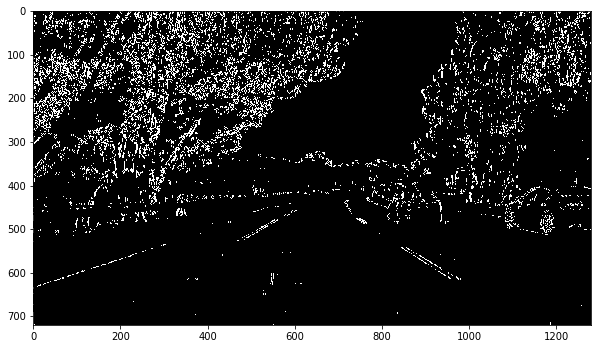

In [10]:
image_example = mpimg.imread('test_images/test5.jpg')
# image_example = warped

image_axis_x = single_axis_threshold(image_example, axis='x', sobel_kernel=5,thresh=(30,80))

plt.imshow(image_axis_x, cmap='gray')

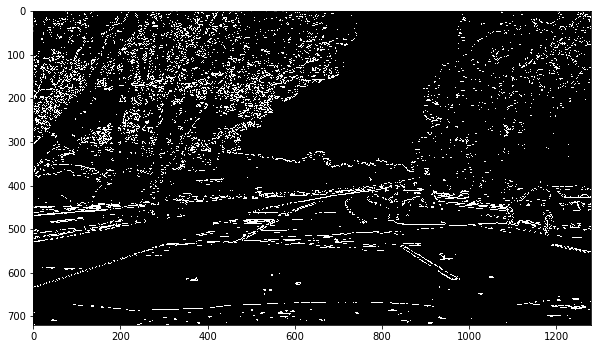

In [11]:
image_axis_y = single_axis_threshold(image_example, axis='y', sobel_kernel=3,thresh=(30,80))

plt.imshow(image_axis_y, cmap='gray')

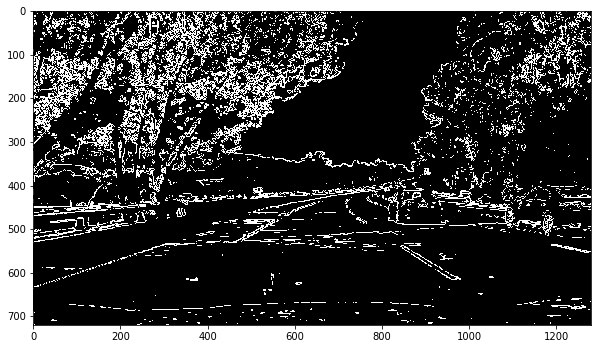

In [12]:
image_mag = mag_threshold(image_example, sobel_kernel=3,thresh=(30,100))

plt.imshow(image_mag, cmap='gray')

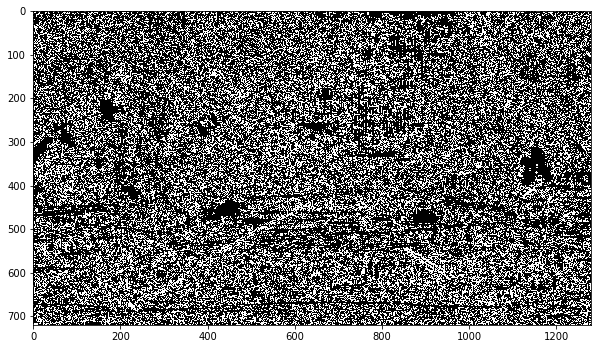

In [13]:
image_dir = dir_threshold(image_example, sobel_kernel=3, thresh=(0.7, 1.3))

plt.imshow(image_dir, cmap='gray')

### Combine Gradient Images

In [8]:
combined_grad = np.zeros_like(image_axis_x)

combined_grad[((image_axis_x == 1) )#& (image_axis_y == 1)) 
              | ((image_mag == 1) & (image_dir == 1))] = 1

plt.imshow(combined_grad, cmap='gray')

NameError: name 'image_axis_x' is not defined

## Combine Colors and Gradient

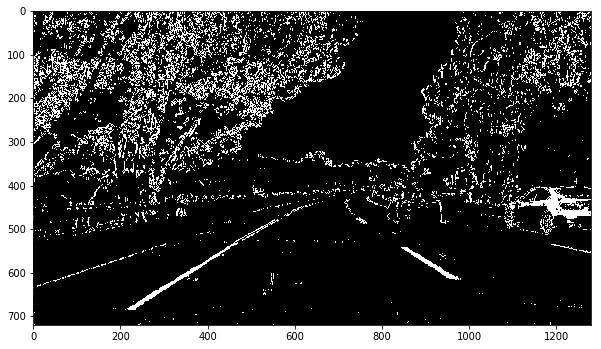

In [15]:
combined_all = np.zeros_like(combined_grad)

combined_all[((combined_color == 1) | (combined_grad == 1))] = 1

plt.imshow(combined_all, cmap='gray')

## Line Detection Function
---
Let's now encapsulate everything that was done so far into a single function.

In [9]:
def binary_image(image):
    # Apply color filters
    image_HSV_V = threshold_image(image, channel=2, thresh=(220,255), ft='HSV')
    image_HLS_S = threshold_image(image, channel=2, thresh=(90,255), ft='HLS')
    # Combine color images
    combined_color = np.zeros_like(image_HSV_V)
    combined_color[((image_HSV_V == 1) & (image_HLS_S == 1))] = 1
    
    # Apply Gradient filters
    image_axis_x = single_axis_threshold(image, axis='x', sobel_kernel=5,thresh=(20,100))
    image_axis_y = single_axis_threshold(image, axis='y', sobel_kernel=3,thresh=(20,100))
    image_mag = mag_threshold(image, sobel_kernel=3,thresh=(30,100))
    image_dir = dir_threshold(image, sobel_kernel=3, thresh=(0.7, 1.3))
    # Combine Gradient images
    combined_grad = np.zeros_like(image_axis_x)
    combined_grad[((image_axis_x == 1) & (image_axis_y == 1)) 
              | ((image_mag == 1) & (image_dir == 1))] = 1

    # Combine color and gradient
    combined_all = np.zeros_like(combined_grad)
    combined_all[((combined_color == 1) | (combined_grad == 1))] = 1
    
    return combined_all

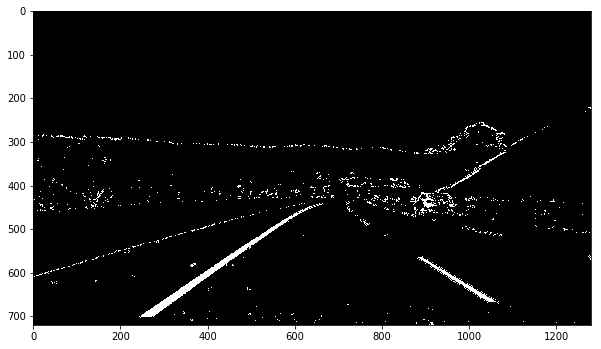

In [10]:
image = mpimg.imread('test_images/test3.jpg')
image = undistort(image)

detection = binary_image(image)

plt.imshow(detection, cmap='gray')

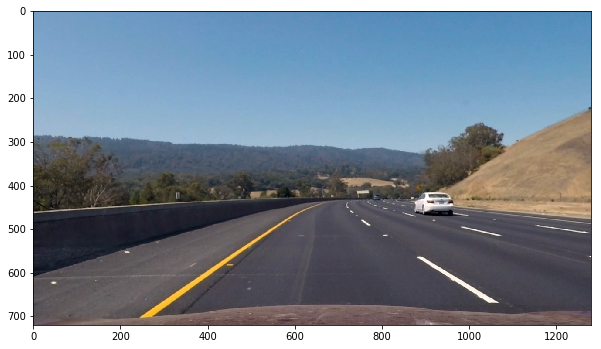

In [23]:
plt.imshow(image, cmap='gray')

## Bird View
---
Pipeline able to change the perspective of the image with the objective of creating a "bird view".

In order to perform the warping it is necessary to identify points 4 points of the road in the original image (corners of the red polygon) and where they will be warpped to (corners of the green polygon).

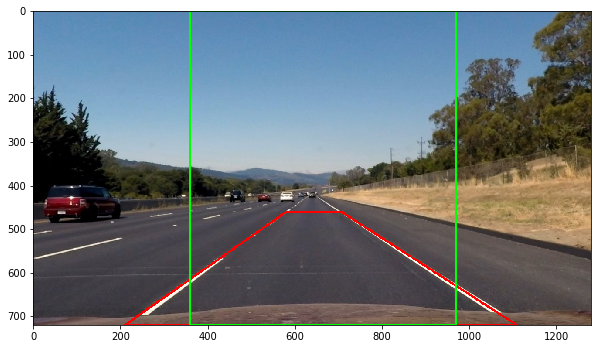

In [11]:
image = mpimg.imread('test_images/straight_lines2.jpg')
image = undistort(image)
warp_template = np.copy(image)

top_left = (580,460)
top_right = (707,460)
bottom_left = (210,720)
bottom_right = (1110,720)

src = np.float32([[bottom_left, top_left, top_right, bottom_right]])

left_bound, right_bound = (360, 970)

top_left = (left_bound,0)
top_right = (right_bound,0)
bottom_left = (left_bound,720)
bottom_right = (right_bound,720)

dst = np.float32([[bottom_left, top_left, top_right, bottom_right]])

road_trapezoid = np.array(src, np.int32)
road_square = np.array(dst, np.int32)

cv2.polylines(warp_template,[road_trapezoid],True,(255,0,0), thickness = 3)
cv2.polylines(warp_template,[road_square],True,(0,255,0), thickness = 3)

plt.imshow(warp_template)

### Generate a warped image

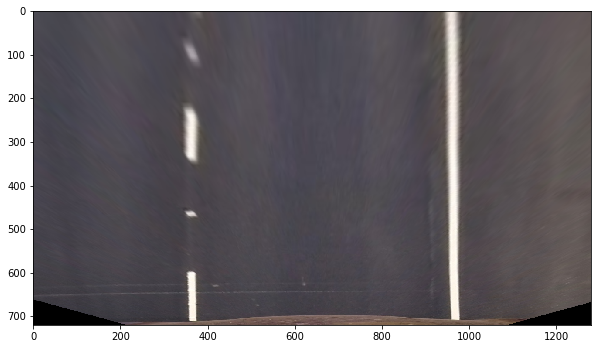

In [25]:
img_x, img_y, chn = image.shape

M = cv2.getPerspectiveTransform(src, dst)

warped = cv2.warpPerspective(image, M, (img_y, img_x))

plt.imshow(warped)

### Function to warp images
---
Time to put the warping process inside a function.

In [12]:
''' 
    This function takes an images and returns a bird-view perspective 
    of it with the transformation matrix used 
'''

def bird_eye(image):
    top_left = (580,460)
    top_right = (707,460)
    bottom_left = (210,720)
    bottom_right = (1110,720)
    src = np.float32([[bottom_left, top_left, top_right, bottom_right]])

    left_bound, right_bound = (360, 970)
    top_left = (left_bound,0)
    top_right = (right_bound,0)
    bottom_left = (left_bound,720)
    bottom_right = (right_bound,720)
    dst = np.float32([[bottom_left, top_left, top_right, bottom_right]])

    img_x, img_y, chn = image.shape

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (img_y, img_x))
    return M,warped

### The pipeline so far ...

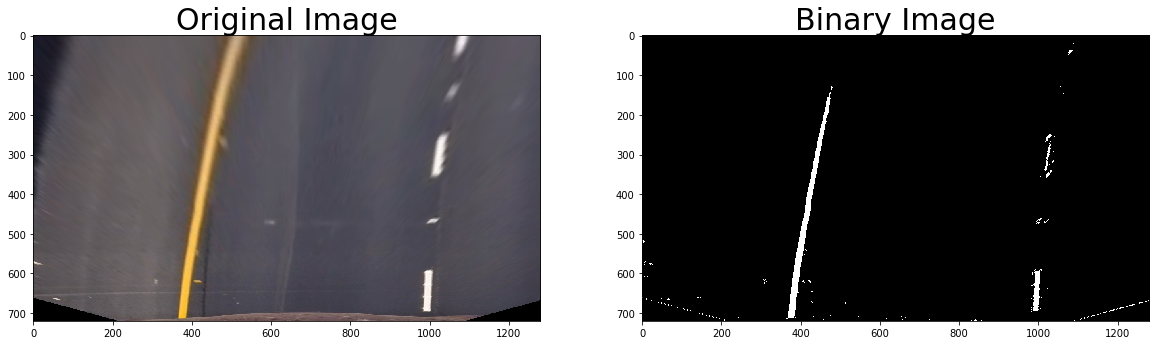

In [13]:
image = mpimg.imread('test_images/test3.jpg')
image = undistort(image)

M, warped = bird_eye(image)

binary = binary_image(warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(warped)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Binary Image', fontsize=30)

### Image histogram
---
The peaks will tell us where the lines are.

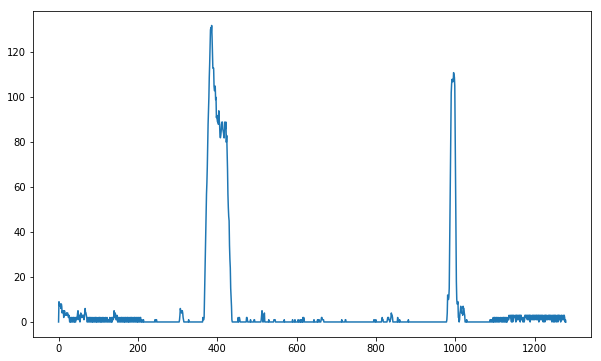

In [14]:
import numpy as np
histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
plt.plot(histogram)

## Line Detection Functions

In [15]:
''' 
The sliding window function breaks the lines in many spices in order to fit a polynomial
that will follow the line
'''

def sliding_window_polyfit(binary, nwindows=9, margin=100, minpix=50, plot=False):
    if plot:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary, binary, binary))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    # Left Peak X position
    leftx_base = np.argmax(histogram[:midpoint])
    # Right Peak X position
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary.shape[0] - (window+1)*window_height
        win_y_high = binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if plot:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if plot:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, left_fitx, right_fit, right_fitx, ploty


'''
Once you already have a polynomial function is not necessary to use the sliding windows
anymore, instead a function that updates the polinommial with the new image should be enough
'''

def update_polyfit(binary, left_fit, right_fit):
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, left_fitx, right_fit, right_fitx, ploty


'''
Compute the vehicle curvature having the polynomial for each line
'''

def curvatures(y_eval, left_fitx, right_fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad


pixe2meters = {'y':30/720, 'x':3.7/700}


def curvature(y_eval, fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = pixe2meters['y'] # meters per pixel in y dimension
    xm_per_pix = pixe2meters['x'] # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curve_meters = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    # Now our radius of curvature is in meters
    return curve_meters

''' Compute the distance from the lane to the center of the vehicle '''

vehicle_center = (640, 719)

def distance_center(fitx):
    return (fitx[vehicle_center[1]] - vehicle_center[0]) * pixe2meters['x']

Running the sliding window:
* Red: Left Line
* Blue: Right Line
* Yellow: polynomial aproximation
* Green: windows

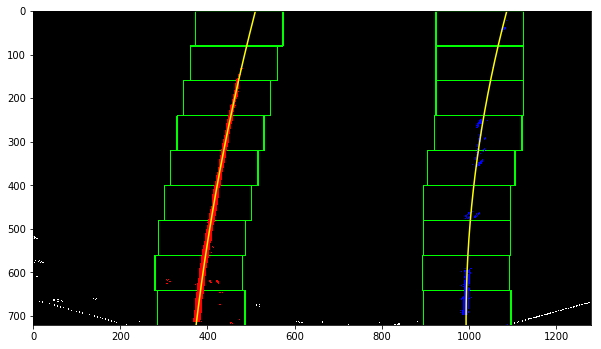

In [16]:
left_fit, left_fitx, right_fit, right_fitx, ploty  = sliding_window_polyfit(binary, plot=True)

Calculate the curvature of the turn in meters

In [19]:
curvature(720, left_fitx, ploty), curvature(720, right_fitx, ploty) 

(1726.2101996397328, 886.21639756317302)

Calculate the distance between the lane and the center of the vehicle in meters

In [20]:
distance_center(left_fitx), distance_center(right_fitx)

(-1.4049818867687167, 1.8673534173048139)

### Function to Draw on Image
---
This function will draw on image and warpit back to the original shape.

In [17]:
def back_to_original(undist, warped, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

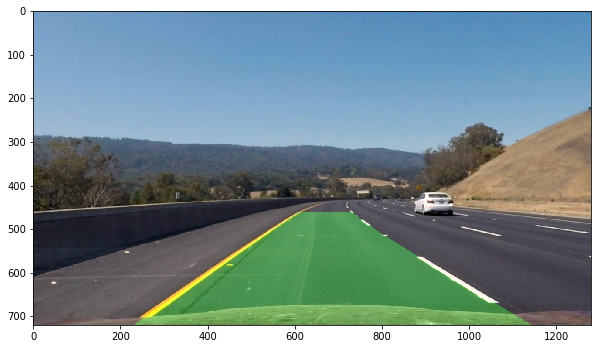

In [18]:
marked_image = back_to_original(image, binary, inv(M), left_fitx, right_fitx, ploty)

plt.imshow(marked_image)

## Line Detection Pipeline
---
Create a function that aplies all that was showed so far and return a marked image.

In [21]:
def pipeline(raw_image):
    # 1 - Undistort Image
    image = undistort(raw_image)
    # 2 - Warp Image
    M, warped = bird_eye(image)
    # 3 - Binnary Warped Image
    binary = binary_image(warped)    
    # 4 - Apply Sliding Window
    left_fit, left_fitx, right_fit, right_fitx, ploty  = sliding_window_polyfit(binary, plot=False)
    # 5 - Draw Road on the Original Image
    marked_image = back_to_original(image, binary, inv(M), left_fitx, right_fitx, ploty)
    return marked_image

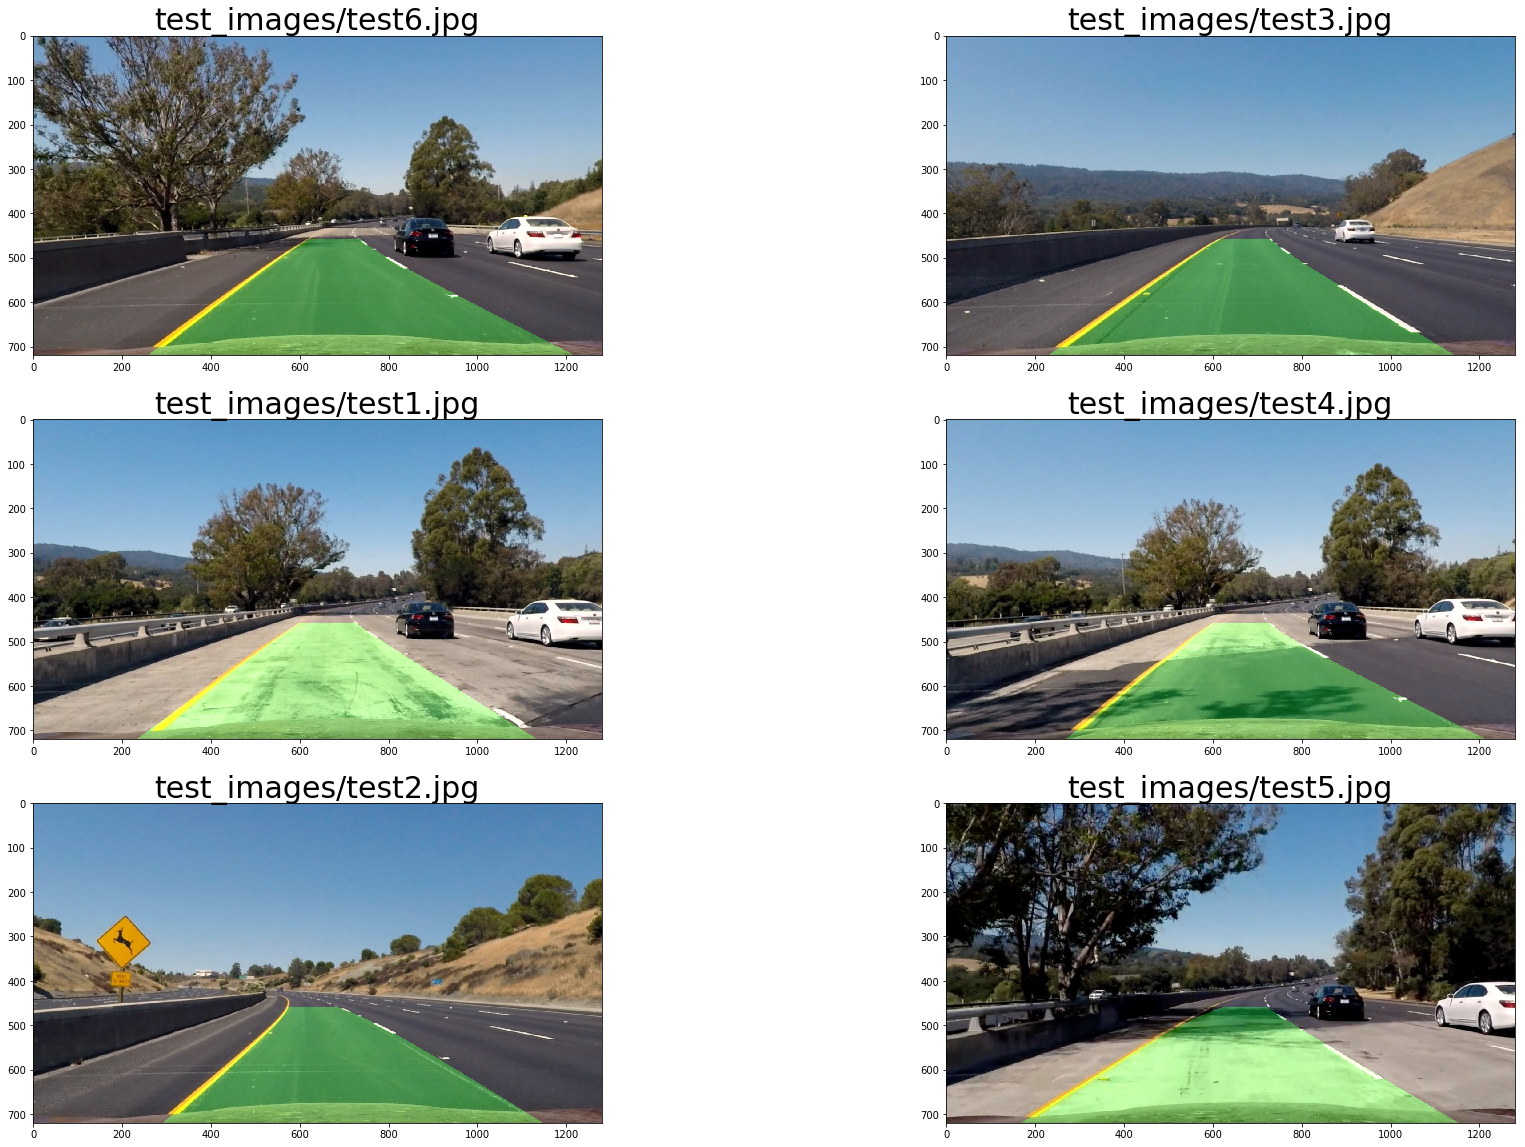

In [22]:
images = glob.glob('test_images/test*.jpg')

n_images = len(images)

f, plots = plt.subplots(int(ceil(n_images/2)), 2, figsize=(30,20))
plots = plots.flatten()

for i, img in enumerate(images):
    image = mpimg.imread(img)
    out = pipeline(image)
    plots[i].imshow(out)
    plots[i].set_title(img, fontsize=30)

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [24]:
white_output = 'out_test.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

clip1 = VideoFileClip("project_video.mp4").subclip(35,43)

# clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video out_test.mp4
[MoviePy] Writing video out_test.mp4


100%|█████████▉| 200/201 [02:16<00:00,  1.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_test.mp4 

CPU times: user 2min 27s, sys: 22.3 s, total: 2min 50s
Wall time: 2min 17s


## Class Line
---
This class will assist detect the line in a video. It will help to define when to use the sliding window methodod or just expand on the existing line polygon.

In [ ]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [ ]:
# Number of fits to average on
N = 10
count_before_reset = 0
reset_threshold = 5

curvature_tolerance = 1000
x_dist_tolerance = (3.6, 3.8)

def sanity_check(left_line, right_line):
    print("Curve =", left_line.radius_of_curvature, right_line.radius_of_curvature, abs(left_line.radius_of_curvature - right_line.radius_of_curvature))
    print("Center =", abs(left_line.line_base_pos), abs(right_line.line_base_pos))
    
    if abs(left_line.radius_of_curvature - right_line.radius_of_curvature) > curvature_tolerance:
        return False
    elif not(x_dist_tolerance[0] <= (abs(left_line.line_base_pos) + abs(right_line.line_base_pos)) <= x_dist_tolerance[1]):
        return False
    # Not sure on how to know if they are paralel should I compare the coeficients?
    else:
        return True


def drawing(image, binary, M, left_line, right_line, ploty):
    drawed = back_to_original(image, binary, inv(M), left_line.bestx, right_line.bestx, ploty)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Radius Curvature = {}(m)'.format(round(left_line.radius_of_curvature,2))
    cv2.putText(drawed,text,(10,50), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    text = 'Left curve to center = {}(m)'.format(round(left_line.line_base_pos,2))
    cv2.putText(drawed,text,(10,100), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    text = 'Distance to Center: Right Curve {}(m)'.format(round(right_line.line_base_pos, 2))
    cv2.putText(drawed,text,(10,150), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    return drawed


def reset(binary):
    print('\nRESETTING\n')
    # Apply Sliding Window
    left_fit, left_fitx, right_fit, right_fitx, ploty = sliding_window_polyfit(binary, plot=False)   
    
    left_line = Line()
    left_line.detected = True
    left_line.recent_xfitted = left_fitx
    left_line.bestx = left_fitx
    left_line.best_fit = left_fit
    left_line.current_fit = left_fit
    left_line.radius_of_curvature = curvature(vehicle_center[1], left_fitx, ploty)
    left_line.line_base_pos = distance_center(left_fitx)
    left_line.allx = [left_fitx]
    left_line.ally = [ploty]
    
    right_line = Line()
    right_line.detected = True
    right_line.recent_xfitted = right_fitx
    right_line.bestx = right_fitx
    right_line.best_fit = right_fit
    right_line.current_fit = right_fit
    right_line.radius_of_curvature = curvature(vehicle_center[1], right_fitx, ploty)
    right_line.line_base_pos = distance_center(right_fitx)
    right_line.allx = [right_fitx]
    right_line.ally = [ploty]
    
    count_before_reset = 0
    
    return left_line, right_line, ploty

scoop = None

def smoothing(line, ploty):
    global N, scoop
    # Get the points from the past N frames
    
    pastx = np.concatenate(line.allx[-N:])
    pasty = np.concatenate(line.ally[-N:])
    
    # Get new averaged fit
    line.best_fit = np.polyfit(np.concatenate([pasty, ploty]), np.concatenate([pastx, line.recent_xfitted]), 2)

    # Get best X
    line.bestx = line.best_fit[0]*ploty**2 + line.best_fit[1]*ploty + line.best_fit[2]
    
    line.allx.append(line.bestx)
    line.ally.append(ploty)


def handle_good_lines(left_line, right_line, ploty):
    # Update Line Fields
    # was the line detected in the last iteration?
    left_line.detected = True
    right_line.detected = True
    
    # Average N fits
    smoothing(left_line, ploty)
    smoothing(right_line, ploty)
    
    return left_line, right_line, ploty


def handle_bad_lines(left_line, right_line, ploty):
    return left_line, right_line, ploty
        

def look_ahead(binary, left_line, right_line):
    global count_before_reset, reset_threshold
    
    print("\n@@ LOOK AHEAD\n")
    
    # Update the polyfit with new warped binary image
    left_fit, left_fitx, right_fit, right_fitx, ploty = update_polyfit(binary, left_line.best_fit, right_line.best_fit)
    
    # Update current fit/pts
    left_line.current_fit = left_fit
    left_line.recent_xfitted = left_fitx
    
    right_line.current_fit = right_fit
    right_line.recent_xfitted = right_fitx    
        
    # Update curvature
    left_line.radius_of_curvature = curvature(vehicle_center[1], left_fitx, ploty)
    right_line.radius_of_curvature = curvature(vehicle_center[1], right_fitx, ploty)
    
    # Update distance to center of the vehicle
    left_line.line_base_pos = (left_fitx[vehicle_center[1]] - vehicle_center[0]) * pixe2meters['x']
    right_line.line_base_pos = (right_fitx[vehicle_center[1]] - vehicle_center[0]) * pixe2meters['x']
    
    check = sanity_check(left_line, right_line)
    print("Sanity:", check)
    
    # Check if a good line was detected
    if check:
        return handle_good_lines(left_line, right_line, ploty)
    else:
        # Test if should reset
        count_before_reset += 1
        if(count_before_reset == reset_threshold):
            return reset(binary)
        else:
            return handle_bad_lines(left_line, right_line, ploty)

In [ ]:
n_frames = 0
left_line, right_line, ploty = (None, None, None)


def final_pipeline(raw_image):
    global n_frames, left_line, right_line, ploty
    # 1 - Undistort Image
    image = undistort(raw_image)
    # 2 - Warp Image
    M, warped = bird_eye(image)
    # 3 - Binnary Warped Image
    binary = binary_image(warped)    

    left_line, right_line, ploty = reset(binary)
    
#     if(n_frames == 0):
#         left_line, right_line, ploty = reset(binary)
#     else:
#         left_line, right_line, ploty = look_ahead(binary, left_line, right_line)
        
#     n_frames += 1
    
    marked_image = drawing(image, binary, M, left_line, right_line, ploty)
    
    return marked_image
    
    

In [ ]:
white_output = 'output_final1.mp4'
n_frames = 0
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

# clip1 = VideoFileClip("project_video.mp4").subclip(24,27)

# clip1 = VideoFileClip("project_video.mp4").subclip(0,3)

clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(final_pipeline) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
import cv2

vidcap = cv2.VideoCapture('project_video.mp4')
vidcap.set(cv2.CAP_PROP_POS_MSEC,24000)      # just cue to 20 sec. position
success,image = vidcap.read()
count = 0
success = True
while success:
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  cv2.imwrite("Frames/frame%d.jpg" % count, image)     # save frame as JPEG file
  count += 1

In [ ]:
raw_image = mpimg.imread('Frames/frame603.jpg')

# 1 - Undistort Image
image = undistort(raw_image)
# 2 - Warp Image
M, warped = bird_eye(image)
# 3 - Binnary Warped Image
binary = binary_image(warped)    
# 4 - Apply Sliding Window
left_fit, left_fitx, right_fit, right_fitx, ploty  = sliding_window_polyfit(binary, plot=False)
# 5 - Draw Road on the Original Image
marked_image = back_to_original(image, binary, inv(M), left_fitx, right_fitx, ploty)

plt.imshow(marked_image)

In [ ]:
test = list(range(10))

In [ ]:
test[-15:]

In [ ]:
test = [np.array]

In [ ]:
test = [left_fitx, right_fitx]

In [ ]:
len(test)

In [ ]:
type(left_fitx)

In [ ]:
test = [np.array([1,2,3]),np.array([1,2,3])]

In [ ]:
np.concatenate(test)

In [ ]:
test1[-3:]

In [ ]:
# Assuming the vehicle center is the center of each picture in px
vehicle_center = (640, 719)

class Line():
    def __init__(self, n = 5):
        # n value of points to keep
        self.n = n
        self.count = 0
        
        # was the line detected in the last iteration?
        self.detected = False 
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #list for the number of points added for each new fit
        self.fit_list = [np.array([False])]
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None
       
    # Set the distance between the center of the vehicle and the new line
    def set_line_base_pos(self, x_pts):
        global pixe2meters, vehicle_center
        self.line_base_pos = (x_pts[vehicle_center[1]] - vehicle_center[0]) * pixe2meters['x']
      
    def set_radius_of_curvature(self, x_pts, y_pts):
        self.radius_of_curvature = curvature(vehicle_center[1], x_pts, y_pts)
    
    def set_best_fit(self):
        pass
    
    def add
        
        
    def first_fit(self, poly, x_pts, y_pts):
        self.current_fit = poly
        self.allx = x_pts
        self.ally = y_pts
        
        self.set_line_base_pos(x_pts)
        self.set_radius_of_curvature(x_pts, y_pts)
        
        
    def add_fit(self, poly, x_pts, y_pts):
        
        
        
        

In [ ]:
class Pipeline():
    
    def __init__(self, initial_image):
        self.current_image = None
        self.current_M = None
        self.current_binary = None
        self.left_line = None
        self.right_line = None
        
        self.process_image(initial_image)
        self.reset()
        
        
    def sanity_check(self):
        pass


    def look_ahead(self):
        pass


    def reset(self):
        # Apply Sliding Window
        left_fit, left_fitx, right_fit, right_fitx, ploty  = sliding_window_polyfit(binary, plot=False)
        
        self.left_line = Line()
        self


    def smoothing(self):
        pass


    def drawing(self):
        pass


    def process_image(self, image):
        # Undistort Image
        self.current_image = undistort(raw_image)
        # Warp Image
        self.current_M, warped = bird_eye(self.current_image)
        # Binnary Warped Image
        self.current_binary = binary_image(warped)
    
    
    def input_image(self, image):
        # Undistort Image
        image = undistort(raw_image)
        # Warp Image
        M, warped = bird_eye(image)
        # Binnary Warped Image
        binary = binary_image(warped)

        # Check if already have detected a line
        if(self.detected):
            self.look_ahead()

        else:
            # Apply Sliding Window
            left_fit, left_fitx, right_fit, right_fitx, ploty  = sliding_window_polyfit(binary, plot=False)

        # 5 - Draw Road on the Original Image
        marked_image = back_to_original(image, binary, inv(M), left_fitx, right_fitx, ploty)

        return marked_image

## Line Detection Pipeline
---
Create a function that aplies all that was showed so far and return a marked image.

In [ ]:
def pipeline(raw_image):
    # 1 - Undistort Image
    image = undistort(raw_image)
    # 2 - Warp Image
    M, warped = bird_eye(image)
    # 3 - Binnary Warped Image
    binary = binary_image(warped)    
    # 4 - Apply Sliding Window
    left_fit, left_fitx, right_fit, right_fitx, ploty  = sliding_window_polyfit(binary, plot=False)
    # 5 - Draw Road on the Original Image
    marked_image = back_to_original(image, binary, inv(M), left_fitx, right_fitx, ploty)
    
    return marked_image

### Test for all the testing images

In [ ]:
images = glob.glob('test_images/test*.jpg')

n_images = len(images)

f, plots = plt.subplots(int(ceil(n_images/2)), 2, figsize=(30,20))
plots = plots.flatten()

for i, img in enumerate(images):
    image = mpimg.imread(img)
    out = pipeline(image)
    plots[i].imshow(out)
    plots[i].set_title(img, fontsize=30)

## Class Line
---
This class will assist detect the line in a video. It will help to define when to use the sliding window methodod or just expand on the existing line polygon.

In [ ]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None